In [ ]:
# @title Install components
# for running Ollama in Google colab
!sudo apt-get install zstd
!curl https://ollama.ai/install.sh | sh
!pip install ollama

!echo 'debconf debconf/frontend select Noninteractive' | sudo debconf-set-selections
!sudo apt-get update && sudo apt-get install -y cuda-drivers

import os
# Set LD_LIBRARY_PATH so the system NVIDIA library
os.environ.update({'LD_LIBRARY_PATH': '/usr/lib64-nvidia'})

In [ ]:
# @title Start server
import subprocess
proccess = subprocess.Popen(['ollama', 'serve'])

In [ ]:
# @title Install urban-worm
%pip install urban-worm --upgrade

In [1]:
# @title Import package
from urbanworm.inference import llama
from urbanworm.dataset import GeoTaggedData

14 buildings found in the bounding box.


<Axes: >

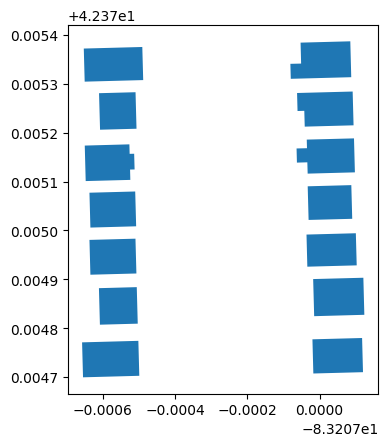

In [3]:
# @title Get building footprints from OSM
# Initiate the constructor
gtd = GeoTaggedData()
# Define the area of interest using a bounding box (bbox)
bbox = (-83.208003,42.374646,-83.206608,42.375328) # in Detroit, USA
# we can just get house with no more than 200 square meter (single family houses with garage excluded)
gtd.getBuildings(bbox, min_area=60, max_area=200)
gtd.units.plot()

In [4]:
# @title Retrieve street views and pass the dataset to inference constructor
key = 'MLY|6978895318888980|51c1e224ebaf1cab65b17c91b612bac9' # @param {"type":"string"}
distance = 30 # @param {"type":"integer"}
pano = True # @param ["False", "True"] {type:"raw"}
reoriented = True  # @param ["False", "True"] {type:"raw"}
multi_num = 3  # @param {type:"slider", min:1, max:3, step:1}
fov = 60  # @param {type:"slider", min:50, max:100, step:1}
interval = 1  # @param {"type":"integer"}
time_of_day = 'day'  # @param ['day', 'night']

gtd.get_svi_from_locations(key = str(key), # Mapillary api key
                           distance = int(distance),       # only search for available street view with 30 meters from the house location
                           pano = bool(pano),         # only search for 360-degree street view images
                           reoriented = bool(reoriented),   # reorient and crop the street view images to make them only frame the house at the center of scene
                           multi_num = int(multi_num),       # return three closest street views from the house location
                           fov = int(fov),            # The field of view in degrees for the reoriented images
                           interval = int(interval),        # The interval between each street view (i.g, `interval = 2` means there should be two available images between two collected images)
                           time_of_day = str(time_of_day),  # only search for images captured during the daytime
                           )

# indicate that the street view images wil be used
gtd.set_images('svi')
# pass the dataset to the inference constructor
data = llama.InferenceOllama(geo_tagged_data=gtd)

  0%|          | 0/14 [00:00<?, ?it/s]

In [6]:
# @title input model repo
model = 'gemma3' # @param {"type":"string"}
data.llm = model

In [7]:
# @title Define schema
from typing import Literal
data.schema = {
    "answer": (Literal['occupied', 'unoccupied'], ...),
    "explanation": (str, ...),
}

In [8]:
# @title Set prompt and run inference
prompt = '''
    Question: Does this house look occupied if it is not a vacant lot?

    **An occupied house means that the house is not abandoned and
    some people may live in this house even if there is not people outside**
'''

data.batch_inference(prompt=prompt)

Processing...: 100%|███████████████████████| 42/42 [07:11<00:00, 10.26s/it]


,answer1,explanation1,data
0,occupied,"The presence of well-maintained landscaping, a...",iVBORw0KGgoAAAANSUhEUgAAArwAAAH0CAIAAABQO2mIAA...
1,occupied,"The presence of well-maintained landscaping, a...",iVBORw0KGgoAAAANSUhEUgAAArwAAAH0CAIAAABQO2mIAA...
2,occupied,"The presence of well-maintained landscaping, a...",iVBORw0KGgoAAAANSUhEUgAAArwAAAH0CAIAAABQO2mIAA...
3,occupied,"The presence of well-maintained landscaping, a...",iVBORw0KGgoAAAANSUhEUgAAArwAAAH0CAIAAABQO2mIAA...
4,occupied,"The presence of well-maintained surroundings, ...",iVBORw0KGgoAAAANSUhEUgAAArwAAAH0CAIAAABQO2mIAA...
5,occupied,"The presence of well-maintained landscaping, a...",iVBORw0KGgoAAAANSUhEUgAAArwAAAH0CAIAAABQO2mIAA...
6,occupied,The house appears to have a well-maintained la...,iVBORw0KGgoAAAANSUhEUgAAArwAAAH0CAIAAABQO2mIAA...
7,occupied,The house appears to have a well-maintained la...,iVBORw0KGgoAAAANSUhEUgAAArwAAAH0CAIAAABQO2mIAA...
8,occupied,The house appears to have a well-maintained la...,iVBORw0KGgoAAAANSUhEUgAAArwAAAH0CAIAAABQO2mIAA...
9,occupied,The house appears to have a well-maintained la...,iVBORw0KGgoAAAANSUhEUgAAArwAAAH0CAIAAABQO2mIAA...


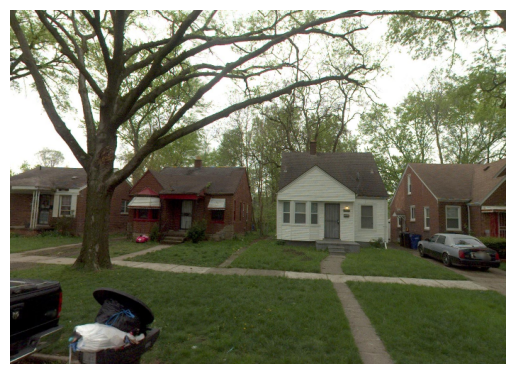

occupied, explanation: The presence of cars, a well-maintained lawn, and visible windows suggest that the house might be occupied.


In [28]:
import base64
from PIL import Image
import matplotlib.pyplot as plt
import io

image_index = 30 # @param {"type":"integer"}
decoded_bytes = base64.b64decode(data.results['data'][image_index])
image_buffer = io.BytesIO(decoded_bytes)
image = Image.open(image_buffer)
plt.imshow(image)
plt.axis('off')
plt.show()
print(f"{data.df['answer1'][image_index]}, explanation: {data.df['explanation1'][image_index]}")